In [1]:
%pylab inline
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.utils import check_random_state
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from statsmodels.graphics.mosaicplot import mosaic

import jsonlines
import ast

Populating the interactive namespace from numpy and matplotlib


In [40]:
X, ys, vectorizer = build_experimental_dataset(
    drug_mincount=50, specialty_mincount=50)

def specialty_mosaic(
        ys, cat2='gender',
        specialty_mincount=1500,
        specialty_maxcount=None):
    cat2 = ys[cat2]
    specialty = ys['specialty']
    dist = specialty.value_counts()
    if specialty_maxcount == None:
        specialty_maxcount = dist.max()    
    subset = [s for s,c in dist.items()
              if c >= specialty_mincount and c <= specialty_maxcount]        
    specialty = specialty[specialty.isin(subset)]
    target_mosaic(cat2, specialty)


def target_mosaic(cat1, cat2, figsize=(18, 4)):
    xtab = pd.crosstab(cat1, cat2).unstack()
    # Bas colors:
    colors = ['#0499CC', '#4D8951', '#FDBA58', '#876DB5',
              '#32A8B4', '#9BB8D7', '#839A8A']        
    color_count = len(colors)
    # These need to be strings for `mosaic`.
    cat1_levels = list(map(str, cat1.value_counts().keys().values))
    cat2_levels = list(map(str, cat2.value_counts().keys().values))
        
    def prop(key):
        """Find the basse color for category c2 and then
        adjust it according to `c1`."""
        c2, c1 = key                       
        cat1_index = cat1_levels.index(c1)
        cat2_index = cat2_levels.index(c2)
        base_color = colors[cat2_index % color_count]
        adjusted = increase_luminance(base_color, multiplier=cat1_index)
        return adjusted
    lab = (lambda key : key[1])
    fig, _ = mosaic(xtab, gap=0.01, labelizer=lab, properties=prop)
    figwidth, figheight = figsize
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    
print specialty_mosaic(ys, cat2='gender')
specialty_mosaic(
    ys, cat2='gender', 
    specialty_mincount=100, specialty_maxcount=300)
    


NameError: name 'build_experimental_dataset' is not defined

In [37]:
#make usable lists out of the dataset

#initialize lists, in which each index refers to a specific physician
gender = []
region = []
settlement_type = []
specialty = []
years_practicing = []

amoxicillin = []
penicillin = []
ibuprofen = []
codeine = []
morphine = []   #we want to include MORPHINE SULFATE ER and MORPHINE SULFATE in this list
amitriptyline_gabapentin = []

#open .jsonl file
with open('practice_500.jsonl', mode='r') as data:     #mode='r' means reading mode
    for obj in data:       
        #convert 'obj' string into dictionary of form 
        #{'provider_variables': {'brand_name_rx_count': 0, 'gender': 'M', 'region': 'South', 'settlement_type': 'non-urban', 'specialty': 'General Practice', 'years_practicing': 7, 'generic_rx_count': 103}, 'npi': '1992715205', 
        #'cms_prescription_counts': {'AMOXICILLIN': 52, 'CEPHALEXIN': 23, 'HYDROCODONE-ACETAMINOPHEN': 28}}
        dic = ast.literal_eval(obj) #dictionary
        #update lists
        gender.append(dic['provider_variables']['gender'])
        region.append(dic['provider_variables']['region'])
        settlement_type.append(dic['provider_variables']['settlement_type'])
        specialty.append(dic['provider_variables']['specialty'])
        years_practicing.append(dic['provider_variables']['years_practicing'])
        #for the drugs, add 0 if the drug has never been prescribed
        if 'AMOXICILLIN' in dic['cms_prescription_counts']:
            amoxicillin.append(dic['cms_prescription_counts']['AMOXICILLIN'])
        else:
            amoxicillin.append(0)
        if 'PENICILLIN V POTASSIUM' in dic['cms_prescription_counts']:
            penicillin.append(dic['cms_prescription_counts']['PENICILLIN V POTASSIUM'])
        else:
            penicillin.append(0)
        if 'IBUPROFEN' in dic['cms_prescription_counts']:
            ibuprofen.append(dic['cms_prescription_counts']['IBUPROFEN'])
        else:
            ibuprofen.append(0)
        if 'ACETAMINOPHEN-CODEINE' in dic['cms_prescription_counts']:
            codeine.append(dic['cms_prescription_counts']['ACETAMINOPHEN-CODEINE'])
        else:
            codeine.append(0)
        #for the drug lists in which 2 different drugs are grouped, add their sum to the list
        if 'MORPHINE SULFATE ER' not in dic['cms_prescription_counts']:
            dic['cms_prescription_counts']['MORPHINE SULFATE ER'] = 0
        if 'MORPHINE SULFATE' not in dic['cms_prescription_counts']:
            dic['cms_prescription_counts']['MORPHINE SULFATE'] = 0
        morphine.append(dic['cms_prescription_counts']['MORPHINE SULFATE ER'] + dic['cms_prescription_counts']['MORPHINE SULFATE'])
        if 'AMITRIPTYLINE HCL' not in dic['cms_prescription_counts']:
            dic['cms_prescription_counts']['AMITRIPTYLINE HCL'] = 0
        if 'GABAPENTIN' not in dic['cms_prescription_counts']:
            dic['cms_prescription_counts']['GABAPENTIN'] = 0
        amitriptyline_gabapentin.append(dic['cms_prescription_counts']['AMITRIPTYLINE HCL'] + dic['cms_prescription_counts']['GABAPENTIN'])
        
#print amoxicillin
#print penicillin
#print ibuprofen
#print codeine
#print morphine
#print amitriptyline_gabapentin
print target_mosaic(ys['gender'], ys['years_practicing'])

NameError: name 'target_mosaic' is not defined

In [3]:
#calculate percentages

#define the maximum value of the list as 100%
def replace_list_by_percentages(lst):
    #maximum value of the list
    mx = max(lst)
    if mx == 0:
        return lst
    else:
        for i in range(0,len(lst)):
            #replace each value in the list by its corresponding percentage
            lst[i] = 100*lst[i]/mx  #percentages already round up/down
        return lst

In [4]:
#eliminate all data containing 0s for both the weak and strong drug that we want to compare

def make_data(gender, years_practicing, weak, strong):
    new_gender = []
    new_y_p = []
    new_weak = []
    new_strong = []
    for i in range(len(weak)):
        if (weak[i] != 0) | (strong[i] != 0):
            new_gender.append(gender[i])
            new_y_p.append(years_practicing[i])
            new_weak.append(weak[i])
            new_strong.append(strong[i])
    return new_gender, new_y_p, new_weak, new_strong

#print make_data(gender, years_practicing, ibuprofen, codeine)

In [5]:
gender_ic, years_practicing_ic, ibuprofen_ic, codeine_ic = make_data(gender, years_practicing, ibuprofen, codeine)
gender_ap, years_practicing_ap, amoxicillin_ap, penicillin_ap = make_data(gender, years_practicing, amoxicillin, penicillin)
gender_am, years_practicing_am, amitriptyline_gabapentin_am, morphine_am = make_data(gender, years_practicing, amitriptyline_gabapentin, morphine)

In [6]:
#function to seperate male and female physycians, to be able to plot them as different colors

def seperator(drug,gender,years_practicing):
    #initialize lists
    arrayM = []
    arrayF = []
    years_M = []
    years_F = []
    for i in range(len(gender)):
        #add data of each gender to specific list
        if gender[i] == "M": 
            arrayM.append(drug[i])
            years_M.append(years_practicing[i])
        if gender[i] == "F": 
            arrayF.append(drug[i])
            years_F.append(years_practicing[i])
    return arrayM,arrayF,years_M,years_F

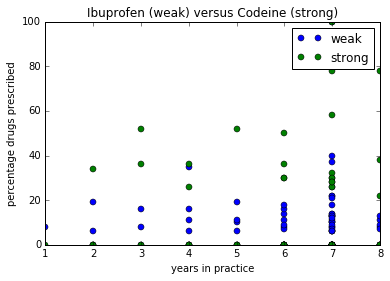

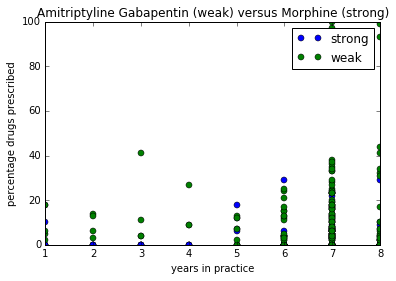

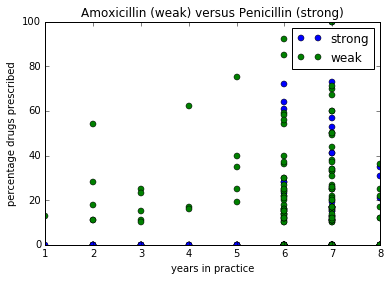

In [7]:
#plot data as strong drug versus weak drug

plot(years_practicing_ic,replace_list_by_percentages(ibuprofen_ic), "o", label='weak')
plot(years_practicing_ic,replace_list_by_percentages(codeine_ic), "o", label='strong')
pylab.legend(loc='upper right')
pylab.xlabel('years in practice')
pylab.ylabel('percentage drugs prescribed')
pylab.title('Ibuprofen (weak) versus Codeine (strong)')
plt.show()
plot(years_practicing_am,replace_list_by_percentages(morphine_am), "o", label='strong')
plot(years_practicing_am,replace_list_by_percentages(amitriptyline_gabapentin_am), "o",  label='weak')
pylab.legend(loc='upper right')
pylab.xlabel('years in practice')
pylab.ylabel('percentage drugs prescribed')
pylab.title('Amitriptyline Gabapentin (weak) versus Morphine (strong)')
pylab.legend(loc='upper right')
plt.show()
plot(years_practicing_ap,replace_list_by_percentages(penicillin_ap), "o", label='strong')
plot(years_practicing_ap,replace_list_by_percentages(amoxicillin_ap), "o",  label='weak')
pylab.legend(loc='upper right')
pylab.xlabel('years in practice')
pylab.ylabel('percentage drugs prescribed')
pylab.title('Amoxicillin (weak) versus Penicillin (strong)')
pylab.legend(loc='upper right')
plt.show()

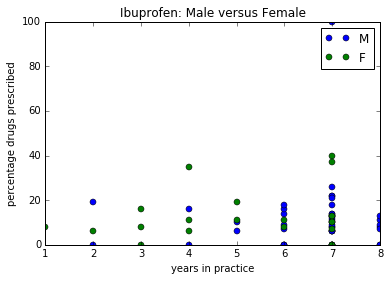

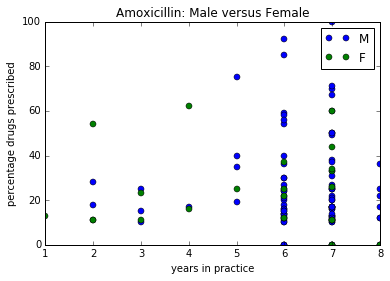

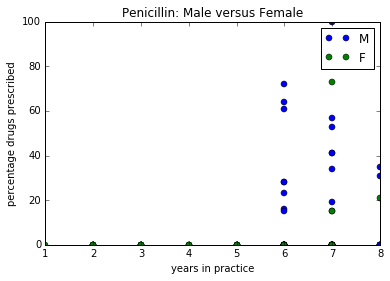

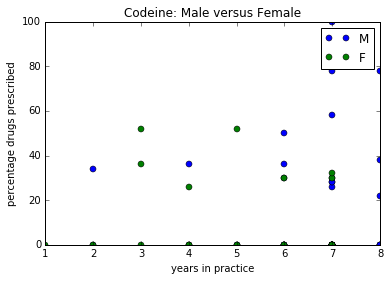

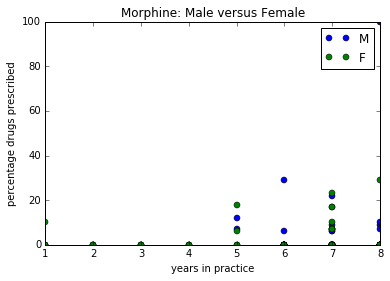

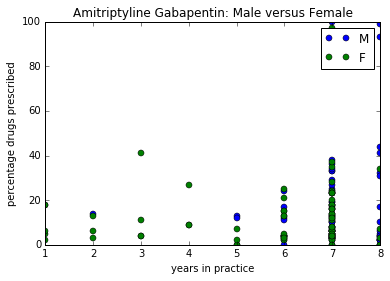

In [8]:
#plot data as female versus male physician

plot(seperator(ibuprofen_ic,gender_ic,years_practicing_ic)[2],
     seperator(ibuprofen_ic,gender_ic,years_practicing_ic)[0], "o", label='M')
plot(seperator(ibuprofen_ic,gender_ic,years_practicing_ic)[3],
     seperator(ibuprofen_ic,gender_ic,years_practicing_ic)[1], "o",  label='F')
pylab.legend(loc='upper right')
pylab.xlabel('years in practice')
pylab.ylabel('percentage drugs prescribed')
pylab.title('Ibuprofen: Male versus Female')
plt.show()

plot(seperator(amoxicillin_ap,gender_ap,years_practicing_ap)[2],
     seperator(amoxicillin_ap,gender_ap,years_practicing_ap)[0], "o", label='M')
plot(seperator(amoxicillin_ap,gender_ap,years_practicing_ap)[3],
     seperator(amoxicillin_ap,gender_ap,years_practicing_ap)[1], "o",  label='F')
pylab.legend(loc='upper right')
pylab.xlabel('years in practice')
pylab.ylabel('percentage drugs prescribed')
pylab.title('Amoxicillin: Male versus Female')
plt.show()

plot(seperator(penicillin_ap,gender_ap,years_practicing_ap)[2],
     seperator(penicillin_ap,gender_ap,years_practicing_ap)[0], "o", label='M')
plot(seperator(penicillin_ap,gender_ap,years_practicing_ap)[3],
     seperator(penicillin_ap,gender_ap,years_practicing_ap)[1], "o",  label='F')
pylab.legend(loc='upper right')
pylab.xlabel('years in practice')
pylab.ylabel('percentage drugs prescribed')
pylab.title('Penicillin: Male versus Female')
plt.show()

plot(seperator(codeine_ic,gender_ic,years_practicing_ic)[2],
     seperator(codeine_ic,gender_ic,years_practicing_ic)[0], "o", label='M')
plot(seperator(codeine_ic,gender_ic,years_practicing_ic)[3],
     seperator(codeine_ic,gender_ic,years_practicing_ic)[1], "o",  label='F')
pylab.legend(loc='upper right')
pylab.xlabel('years in practice')
pylab.ylabel('percentage drugs prescribed')
pylab.title('Codeine: Male versus Female')
plt.show()

plot(seperator(morphine_am,gender_am,years_practicing_am)[2],
     seperator(morphine_am,gender_am,years_practicing_am)[0], "o", label='M')
plot(seperator(morphine_am,gender_am,years_practicing_am)[3],
     seperator(morphine_am,gender_am,years_practicing_am)[1], "o",  label='F')
pylab.legend(loc='upper right')
pylab.xlabel('years in practice')
pylab.ylabel('percentage drugs prescribed')
pylab.title('Morphine: Male versus Female')
plt.show()

plot(seperator(amitriptyline_gabapentin_am,gender_am,years_practicing_am)[2],
     seperator(amitriptyline_gabapentin_am,gender_am,years_practicing_am)[0], "o", label='M')
plot(seperator(amitriptyline_gabapentin_am,gender_am,years_practicing_am)[3],
     seperator(amitriptyline_gabapentin_am,gender_am,years_practicing_am)[1], "o",  label='F')
pylab.legend(loc='upper right')
pylab.xlabel('years in practice')
pylab.ylabel('percentage drugs prescribed')
pylab.title('Amitriptyline Gabapentin: Male versus Female')
plt.show()

In [9]:
#(insertion) sort of all lists on increasing years_practicing
#necessary for our logistic regresion, otherwise the lines connecting the points are random and chaotic

for i in range(1, len(years_practicing_ic)):
    j=i
    while j>0 and years_practicing_ic[j] < years_practicing_ic[j-1]:
        years_practicing_ic[j], years_practicing_ic[j-1] = years_practicing_ic[j-1], years_practicing_ic[j]
        gender_ic[j], gender_ic[j-1] = gender_ic[j-1], gender_ic[j]
#        region[j], region[j-1] = region[j-1], region[j]
#        settlement_type[j], settlement_type[j-1] = settlement_type[j-1], settlement_type[j]
#        specialty[j], specialty[j-1] = specialty[j-1], specialty[j]
#        amoxicillin_ap[j], amoxicillin_ap[j-1] = amoxicillin_ap[j-1], amoxicillin_ap[j]
#        penicillin_ap[j], penicillin_ap[j-1] = penicillin_ap[j-1], penicillin_ap[j]
        ibuprofen_ic[j], ibuprofen_ic[j-1] = ibuprofen_ic[j-1], ibuprofen_ic[j]
        codeine_ic[j], codeine_ic[j-1] = codeine_ic[j-1], codeine_ic[j]
#        morphine_am[j], morphine_am[j-1] = morphine_am[j-1], morphine_am[j]
#        amitriptyline_gabapentin_am[j], amitriptyline_gabapentin_am[j-1] = amitriptyline_gabapentin_am[j-1], amitriptyline_gabapentin_am[j]
        j-=1
        
#print years_practicing

Isotonic regression score of ibuprofen -0.0611324259049
Isotonic regression score of codeine 0.00243300177567


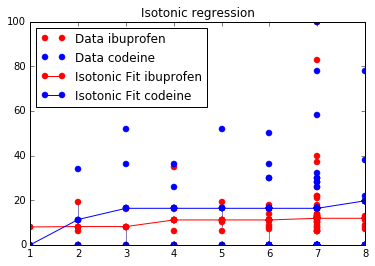

In [10]:
#Isotonic regression

x = years_practicing_ic
y_i = replace_list_by_percentages(ibuprofen_ic)
y_c = replace_list_by_percentages(codeine_ic)
n = len(years_practicing_ic)
ir = IsotonicRegression()

#make arrays out of the lists
x_a = np.array(x)
y_i_a = np.array(y_i)
y_c_a = np.array(y_c)

y_i_f = ir.fit_transform(x_a, y_i_a)
y_c_f = ir.fit_transform(x_a, y_c_a)

#print the score that the fits have
print 'Isotonic regression score of ibuprofen', ir.score(x_a,y_i_a)
print 'Isotonic regression score of codeine', ir.score(x_a,y_c_a)

#prepare segments connecting the points
segments = [[[i, y_i[i]], [i, y_i_f[i]]] for i in range(n)]
lc = LineCollection(segments, zorder=0)
lc.set_array(np.ones(len(y_i)))
lc.set_linewidths(0.5 * np.ones(n))

#plot data and graphs
fig = plt.figure()
plt.plot(x_a, y_i, 'r.', markersize=12)
plt.plot(x_a, y_c, 'b.', markersize=12)
plt.plot(x_a, y_i_f, 'r.-', markersize=12)
plt.plot(x_a, y_c_f, 'b.-', markersize=12)
plt.gca().add_collection(lc)
plt.legend(('Data ibuprofen', 'Data codeine', 'Isotonic Fit ibuprofen', 'Isotonic Fit codeine'), loc='upper left')
plt.title('Isotonic regression')
plt.show()

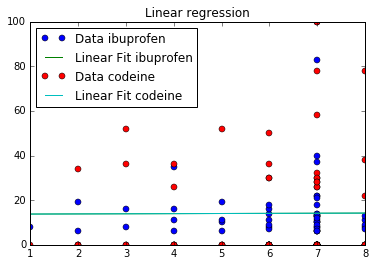

In [11]:
#Linear Regression

#reshape data
x3_i = x_a.reshape(-1, 1)
x3_c = x_a.reshape(-1, 1)

lr = LinearRegression()
lr.fit(x3_i, y_i_a)
lr.fit(x3_c, y_c_a)

#plot data and graphs
plt.plot(x3_i,y_i_a,'o')
plt.plot(x3_i,lr.predict(x3_i))
plt.plot(x3_c,y_c_a,'o')
plt.plot(x3_c,lr.predict(x3_c))
plt.legend(('Data ibuprofen', 'Linear Fit ibuprofen', 'Data codeine', 'Linear Fit codeine'), loc='upper left')
plt.title('Linear regression')
plt.show()

score: 0.676
Classification Report:
             precision    recall  f1-score   support

          F       0.72      0.29      0.41       197
          M       0.67      0.93      0.78       303

avg / total       0.69      0.68      0.63       500

Confusion Matrix:
[[ 57 140]
 [ 22 281]]
0.5 8.5 -0.5 100.5
(20200L,)
(505L, 40L)
(505L, 40L) (505L, 40L) (505L, 40L)
[[ 1.  1.  1. ...,  0.  0.  0.]
 [ 1.  1.  1. ...,  0.  0.  0.]
 [ 1.  1.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


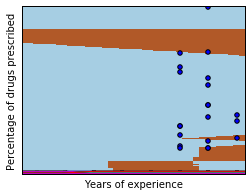

In [61]:
import matplotlib.pyplot as mpl_plt
import matplotlib.pyplot as plt
import pandas as pd


# K-Nearest Neighbor classification

#x-axis: years practicing & percentages, shape 500x2
xKNN = np.column_stack((years_practicing, replace_list_by_percentages(penicillin
)))

#gender = target feature
y = gender

#define k
n_neighbors = 1

#fit data
neigh = KNeighborsClassifier(n_neighbors)
neigh.fit(xKNN, y)
#calculate score of the fit
score = neigh.score(xKNN, y)
print 'score:', score
a = neigh.kneighbors_graph(xKNN, n_neighbors)

expected = y
predicted = neigh.predict(xKNN)

#display the confusion matrix and the classification report
print 'Classification Report:'
print(metrics.classification_report(expected, predicted))
print 'Confusion Matrix:'
print(metrics.confusion_matrix(expected, predicted))

#set the step size in the mesh
h = 0.2

#plot the decision boundary: assign a color to each point in the mesh [x_min, m_max]x[y_min, y_max]
x_min, x_max = xKNN[:,0].min() - .5, xKNN[:,0].max() + .5
y_min, y_max = xKNN[:,1].min() - .5, xKNN[:,1].max() + .5
print x_min, x_max, y_min, y_max
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#define Z as a matrix containing the genders
Z = neigh.predict(np.c_[xx.ravel(), yy.ravel()])
print Z.shape

#put the result into a color plot
Z = Z.reshape(xx.shape)
print Z.shape
plt.figure(1, figsize=(4, 3))
plt.set_cmap(plt.cm.Paired)
print xx.shape, yy.shape, Z.shape
Z = 1.0*(Z=='F')
print Z
plt.plot(Z)
plt.pcolormesh(xx, yy,Z)

#plot the training points

plt.scatter(xKNN[:,0], xKNN[:,1])

plt.xlabel('Years of experience')
plt.ylabel('Percentage of drugs prescribed')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())


plt.show()

In [ ]:
help(pcolormesh)